In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

a)


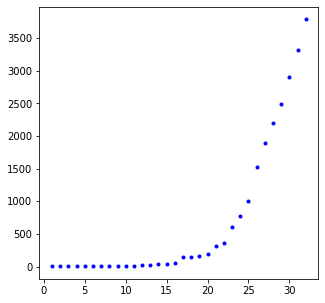

In [20]:
df = pd.read_csv('./covid19.csv', header=None)

x = df[0].to_numpy()
y = df[1].to_numpy()

x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

fig = plt.figure(figsize=(5,5))
print('a)')
plt.plot(x, y, 'b.')

tamanho conjunto de treinamento: 25
tamanho conjunto de validação: 7
Holdout cross-validation (80/20%)
Tempo de execução: 0.1243 [s]

Curvas de aprendizado


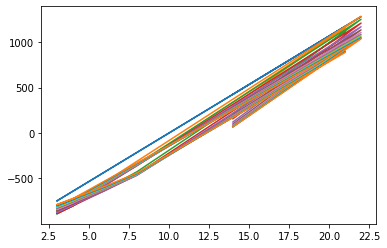

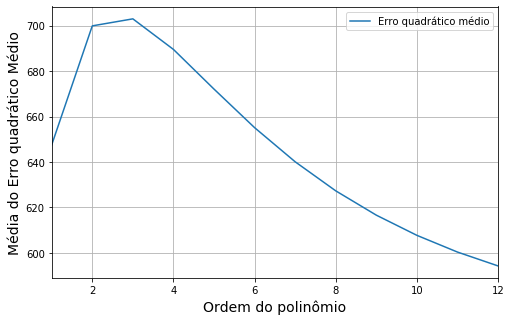

In [21]:
#b)
# Get timestamp of holdout start.
starttime = timeit.default_timer()
include_bias = True

# Split the whole set into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)
print('tamanho conjunto de treinamento:', len(y_train))
print('tamanho conjunto de validação:', len(y_val))

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=1, tol=1, random_state=42)
    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])

    polynomial_regression.fit(x_train, y_train)
    
    y_val_predict = polynomial_regression.predict(x_val)
    
    plt.plot(x_val, y_val_predict, label='Hipótese $\lambda=$'+str(d))

    mean_vec.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

print("Holdout cross-validation (80/20%)")
plt.figure(figsize=(8, 5))
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))
print("\nCurvas de aprendizado")

k-fold cross-validation (k=10)
Tempo de execução: 0.5416 [s]


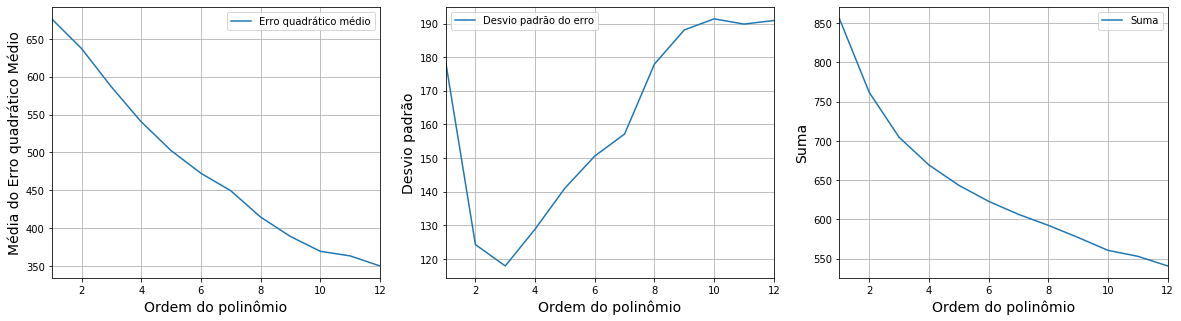

In [22]:
print('k-fold cross-validation (k=10)')

# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=100)

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=1, tol=1, random_state=42)
    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, x, y, scoring='neg_mean_squared_error', cv=kfold)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())

print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

# Plot results.
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 2)
plt.plot(range(1, 13), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 3)
plt.plot(range(1, 13), np.add(mean_vec, std_vec),  label='Suma')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Suma', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

#Show the plot.
plt.show()

kLeave-one-out cross-validation
Tempo de execução: 1.1508 [s]


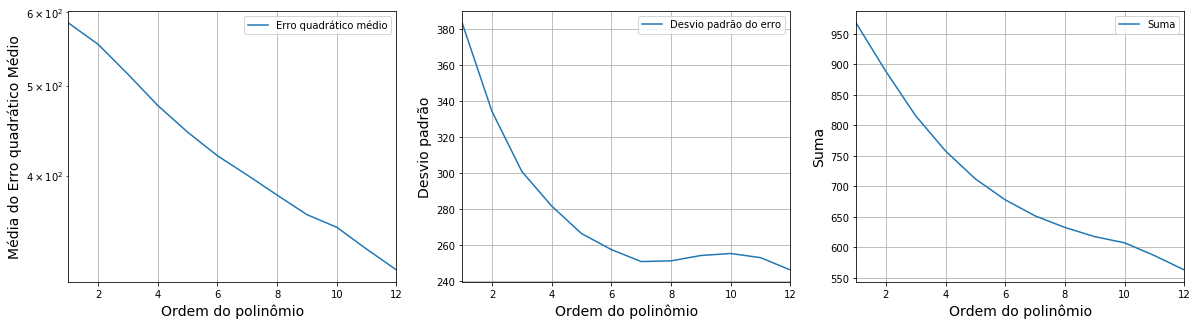

In [23]:
print('kLeave-one-out cross-validation')
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LOOCV object.
loocv = LeaveOneOut()

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=1, tol=1, random_state=42)
    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, x, y, scoring='neg_mean_squared_error', cv=loocv)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

# Plot results.
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.yscale('log')
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
#plt.ylim([0.78, 0.81])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 2)
plt.plot(range(1, 13), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 3)
plt.plot(range(1, 13), np.add(mean_vec, std_vec),  label='Suma')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Suma', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

# Save figure
plt.savefig("leave_one_out.png", dpi=600)
#Show the plot.
plt.show()

In [24]:
#c)
# Instantiate a polynomial with the given degree.
poly_features = PolynomialFeatures(degree=12, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
std_scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = Lasso(alpha=1, tol=1, random_state=42)
# Create a pipeline of actions.
polynomial_regressioncovid = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("reg", reg),
])

polynomial_regressioncovid.fit(x, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=12, include_bias=True,
                                    interaction_only=False, order='C')),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
                       normalize=False, positive=False, precompute=False,
                       random_state=42, selection='cyclic', tol=1,
                       warm_start=False))],
         verbose=False)

dia: 1 -> -428 contagiados
dia: 2 -> -408 contagiados
dia: 3 -> -386 contagiados
dia: 4 -> -361 contagiados
dia: 5 -> -334 contagiados
dia: 6 -> -305 contagiados
dia: 7 -> -272 contagiados
dia: 8 -> -236 contagiados
dia: 9 -> -197 contagiados
dia: 10 -> -154 contagiados
dia: 11 -> -107 contagiados
dia: 12 -> -55 contagiados
dia: 13 -> 1 contagiados
dia: 14 -> 63 contagiados
dia: 15 -> 132 contagiados
dia: 16 -> 207 contagiados
dia: 17 -> 290 contagiados
dia: 18 -> 382 contagiados
dia: 19 -> 483 contagiados
dia: 20 -> 595 contagiados
dia: 21 -> 719 contagiados
dia: 22 -> 858 contagiados
dia: 23 -> 1012 contagiados
dia: 24 -> 1186 contagiados
dia: 25 -> 1382 contagiados
dia: 26 -> 1603 contagiados
dia: 27 -> 1854 contagiados
dia: 28 -> 2141 contagiados
dia: 29 -> 2469 contagiados
dia: 30 -> 2847 contagiados
dia: 31 -> 3285 contagiados
dia: 32 -> 3793 contagiados
dia: 33 -> 4386 contagiados
dia: 34 -> 5080 contagiados
dia: 35 -> 5897 contagiados
dia: 36 -> 6860 contagiados
dia: 37 -> 8000

Text(0, 0.5, 'contagios')

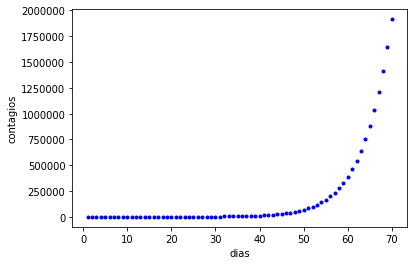

In [28]:
#d)
x_predict = np.linspace(1, 70, 70)
x_predict = x_predict.reshape(len(x_predict),1)
y_predict = polynomial_regressioncovid.predict(x_predict)
for i, value in enumerate(y_predict):
    print('dia: ' + str(i+1) + ' -> ' + str(int(value)) + ' contagiados')
plt.plot(x_predict, y_predict, 'b.')
plt.xlabel('dias')
plt.ylabel('contagios')

In [27]:
for i, value in enumerate(y_predict):
    if value >= 40600:
        print('e) O número de leitos total seria atingido após ' + str(i+1) + ' dias do primeiro caso')
        break

e) O número de leitos total seria atingido após 47 dias do primeiro caso
